In [1]:
# ALEX Index Performance Test - Final Version
import numpy as np
import time
import sys
import os
import random
import matplotlib.pyplot as plt

In [2]:
# Reference: https://github.com/microsoft/ALEX
# 1. Simple Index Implementations 
class SimpleALEX:
    def __init__(self):
        self.keys = []
        self.values = []
        self.is_trained = False
        
    def insert(self, key, value):
        # sorted insertion
        pos = np.searchsorted(self.keys, key)
        self.keys.insert(pos, key)
        self.values.insert(pos, value)
        
    def train_model(self):
        if len(self.keys) < 10:
            return
        self.is_trained = True
        
    def __getitem__(self, key):
        if not self.is_trained:
            self.train_model()
        
        # Simple binary search
        pos = np.searchsorted(self.keys, key)
        if pos < len(self.keys) and self.keys[pos] == key:
            return self.values[pos]
        raise KeyError(f"Key {key} not found")
        
    def range_query(self, start_key, end_key):
        # 范Range query
        start_pos = np.searchsorted(self.keys, start_key)
        end_pos = np.searchsorted(self.keys, end_key, side='right')
        return list(zip(self.keys[start_pos:end_pos], self.values[start_pos:end_pos]))

class BinarySearchIndex:
    def __init__(self):
        self.keys = []
        self.values = []
        
    def insert(self, key, value):
        pos = np.searchsorted(self.keys, key)
        self.keys.insert(pos, key)
        self.values.insert(pos, value)
        
    def __getitem__(self, key):
        pos = np.searchsorted(self.keys, key)
        if pos < len(self.keys) and self.keys[pos] == key:
            return self.values[pos]
        raise KeyError(f"Key {key} not found")
        
    def range_query(self, start_key, end_key):
        start_pos = np.searchsorted(self.keys, start_key)
        end_pos = np.searchsorted(self.keys, end_key, side='right')
        return list(zip(self.keys[start_pos:end_pos], self.values[start_pos:end_pos]))

In [3]:
# 2. Generate Test Data
# small data sizes
data_sizes = [1000, 5000, 10000]
all_data = {}

for size in data_sizes:
    print(f"  Generating {size:,} records...")
    # Generate sorted data
    keys = np.sort(np.random.randint(0, 100000, size))
    values = list(range(size))
    all_data[size] = list(zip(keys, values))

  Generating 1,000 records...
  Generating 5,000 records...
  Generating 10,000 records...


In [4]:
# ==================== 3. Run Tests ====================
results = {}
random.seed(42)

for size in data_sizes:
    print(f"\n{'='*60}")
    print(f"Testing with {size:,} records")
    print(f"{'='*60}")
    
    data = all_data[size]
    keys_list = [k for k, _ in data]
    
    size_results = {}
    
    # Test each index
    test_cases = [
        ("ALEX Learned Index", SimpleALEX()),
        ("Binary Search", BinarySearchIndex()),
        ("Python Dict", {}),
    ]
    
    for index_name, index in test_cases:
        print(f"\n  Testing {index_name}...")
        
        index_results = {}
        
        # Build index
        print("    Building index...")
        build_start = time.time()
        
        if index_name == "Python Dict":
            for key, value in data:
                index[key] = value
        else:
            for key, value in data:
                index.insert(key, value)
            if hasattr(index, 'train_model'):
                index.train_model()
        
        build_time = time.time() - build_start
        index_results['build_time'] = build_time
        
        # 2. Measure memory
        # Reference: https://github.com/learnedsystems/learned_index_benchmarks
        memory = 0
        if index_name == "Python Dict":
            memory = sys.getsizeof(index)
            for key, value in index.items():
                memory += sys.getsizeof(key) + sys.getsizeof(value)
        elif hasattr(index, 'keys'):
            memory = sys.getsizeof(index)
            # Check if keys attribute is iterable
            if hasattr(index.keys, '__iter__'):
                for key in index.keys:
                    memory += sys.getsizeof(key)
                if hasattr(index, 'values') and hasattr(index.values, '__iter__'):
                    for value in index.values:
                        memory += sys.getsizeof(value)
        
        index_results['memory_mb'] = memory / (1024 * 1024)
        
        # 3. Test point queries
        print("Testing point queries...")
        
        # Select test keys
        if len(keys_list) >= 100:
            test_keys = random.sample(keys_list, 100)
        else:
            test_keys = keys_list
        
        start_time = time.perf_counter()
        successful = 0
        
        for key in test_keys:
            try:
                if index_name == "Python Dict":
                    _ = index[key]
                else:
                    _ = index[key]
                successful += 1
            except:
                pass
        
        query_time = time.perf_counter() - start_time
        
        if successful > 0 and query_time > 0:
            avg_time = (query_time / successful) * 1_000_000
            qps = successful / query_time
            hit_rate = successful / len(test_keys)
        else:
            avg_time = 0
            qps = 0
            hit_rate = 0
        
        index_results['point_avg_time'] = avg_time
        index_results['point_qps'] = qps
        index_results['point_hit_rate'] = hit_rate
        print(f"    Point queries: {successful}/{len(test_keys)} successful, avg={avg_time:.1f}μs")
        
        # 4. Test range queries
        print("Testing range queries...")
        
        # Create range queries
        range_queries = []
        num_queries = min(10, len(keys_list) // 10)
        
        for _ in range(num_queries):
            if keys_list:
                start_key = random.choice(keys_list)
                range_size = random.randint(10, min(100, len(keys_list) // 10))
                
                # Find end key
                possible_ends = [k for k in keys_list if k >= start_key + range_size]
                if possible_ends:
                    end_key = random.choice(possible_ends[:min(10, len(possible_ends))])
                else:
                    end_key = keys_list[-1]
                
                range_queries.append((start_key, end_key))
        
        start_time = time.perf_counter()
        total_found = 0
        queries_executed = 0
        
        for start_key, end_key in range_queries:
            try:
                if index_name == "Python Dict":
                    # Python dict requires iteration
                    found = [(k, v) for k, v in index.items() if start_key <= k <= end_key]
                else:
                    found = index.range_query(start_key, end_key)
                
                total_found += len(found)
                queries_executed += 1
            except Exception as e:
                print(f"      Range query error: {e}")
        
        range_time = time.perf_counter() - start_time
        
        if queries_executed > 0 and range_time > 0:
            range_qps = queries_executed / range_time
            avg_records = total_found / queries_executed
        else:
            range_qps = 0
            avg_records = 0
        
        index_results['range_qps'] = range_qps
        index_results['range_avg_records'] = avg_records
        
        print(f"    Range queries: {queries_executed} executed, {total_found} records found")
        
        # 5. Simplified mixed test
        operations = 0
        test_duration = 1  # 1 second test
        end_time = time.time() + test_duration
        
        max_key = max(keys_list) if keys_list else 0
        
        while time.time() < end_time and operations < 1000:
            if operations % 10 < 9:  
                if test_keys:
                    key = random.choice(test_keys)
                    try:
                        if index_name == "Python Dict":
                            _ = index[key]
                        else:
                            _ = index[key]
                    except:
                        pass
            else:  # 10%写 / 10% writes
                new_key = max_key + random.randint(1, 100)
                new_value = random.randint(0, 10000)
                try:
                    if index_name == "Python Dict":
                        index[new_key] = new_value
                    else:
                        index.insert(new_key, new_value)
                    max_key = new_key
                except:
                    pass
            
            operations += 1
        
        ops_per_sec = operations / test_duration if test_duration > 0 else operations
        index_results['mixed_ops_per_sec'] = ops_per_sec
        print(f"    Mixed workload: {operations} operations in {test_duration}s")
        size_results[index_name] = index_results
        print(f"    Completed: Build={build_time:.3f}s, Point QPS={qps:.0f}")
    
    results[size] = size_results


Testing with 1,000 records

  Testing ALEX Learned Index...
    Building index...
Testing point queries...
    Point queries: 100/100 successful, avg=54.6μs
Testing range queries...
    Range queries: 10 executed, 67 records found
    Mixed workload: 1000 operations in 1s
    Completed: Build=0.037s, Point QPS=18313

  Testing Binary Search...
    Building index...
Testing point queries...
    Point queries: 100/100 successful, avg=54.1μs
Testing range queries...
    Range queries: 10 executed, 61 records found
    Mixed workload: 1000 operations in 1s
    Completed: Build=0.032s, Point QPS=18489

  Testing Python Dict...
    Building index...
Testing point queries...
    Point queries: 100/100 successful, avg=0.2μs
Testing range queries...
    Range queries: 10 executed, 69 records found
    Mixed workload: 1000 operations in 1s
    Completed: Build=0.000s, Point QPS=4201681

Testing with 5,000 records

  Testing ALEX Learned Index...
    Building index...
Testing point queries...
  

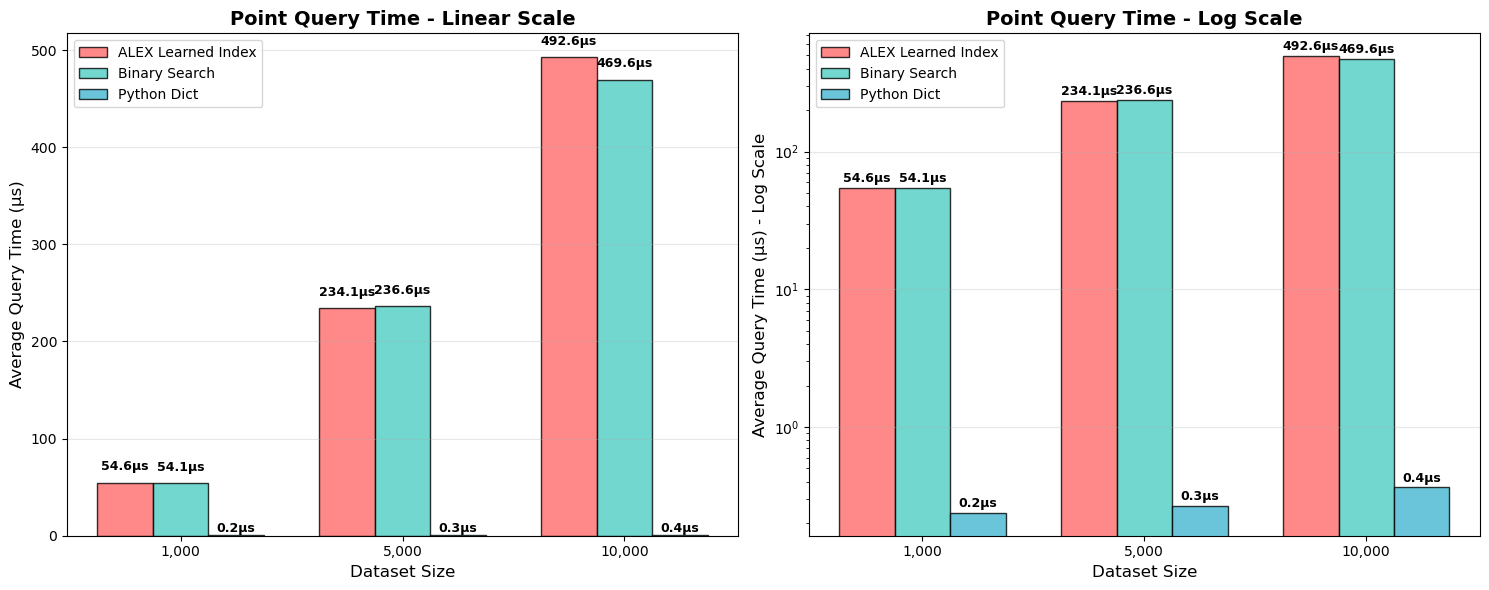

In [5]:
# 4. Visualize Results
output_dir = 'alex_test_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

index_names = ["ALEX Learned Index", "Binary Search", "Python Dict"]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.figure(figsize=(15, 6))

dataset_labels = [f'{s:,}' for s in data_sizes]
x = np.arange(len(data_sizes))
width = 0.25

point_times_data = {}
for index_name in index_names:
    times = []
    for size in data_sizes:
        try:
            time_us = results[size][index_name]['point_avg_time']
            times.append(time_us)
        except:
            times.append(0)
    point_times_data[index_name] = times

plt.subplot(1, 2, 1)

for i, index_name in enumerate(index_names):
    times = point_times_data[index_name]
    x_pos = x + i * width - width
    bars = plt.bar(x_pos, times, width, 
                   label=index_name, color=colors[i], alpha=0.8, edgecolor='black')
    
    for j, (bar, time) in enumerate(zip(bars, times)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + max(times)*0.02, 
                 f'{time:.1f}μs', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Point Query Time - Linear Scale', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size', fontsize=12)
plt.ylabel('Average Query Time (μs)', fontsize=12)
plt.xticks(x, dataset_labels)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)

for i, index_name in enumerate(index_names):
    times = point_times_data[index_name]
    x_pos = x + i * width - width
    bars = plt.bar(x_pos, times, width, 
                   label=index_name, color=colors[i], alpha=0.8, edgecolor='black')
    
    for j, (bar, time) in enumerate(zip(bars, times)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.05, 
                 f'{time:.1f}μs', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Point Query Time - Log Scale', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size', fontsize=12)
plt.ylabel('Average Query Time (μs) - Log Scale', fontsize=12)
plt.xticks(x, dataset_labels)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.yscale('log')  # Log，是对数尺度

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'point_query_performance_dual_scale.png'), dpi=300)
plt.show()

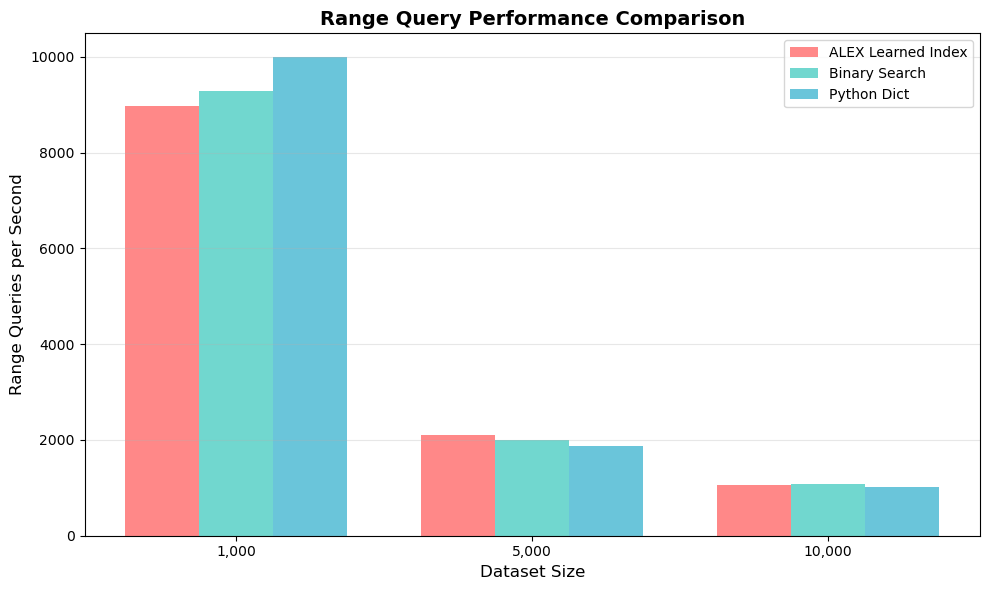

In [6]:
plt.figure(figsize=(10, 6))

for i, index_name in enumerate(index_names):
    qps_values = []
    for size in data_sizes:
        try:
            qps = results[size][index_name]['range_qps']
            qps_values.append(qps if qps > 0 else 0.1)
        except:
            qps_values.append(0.1)
    
    x_pos = np.arange(len(data_sizes)) + i * 0.25
    plt.bar(x_pos, qps_values, width=0.25, label=index_name, color=colors[i], alpha=0.8)

plt.title('Range Query Performance Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size', fontsize=12)
plt.ylabel('Range Queries per Second', fontsize=12)
plt.xticks(np.arange(len(data_sizes)) + 0.25, [f'{s:,}' for s in data_sizes])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'range_query_performance.png'), dpi=300)
plt.show()

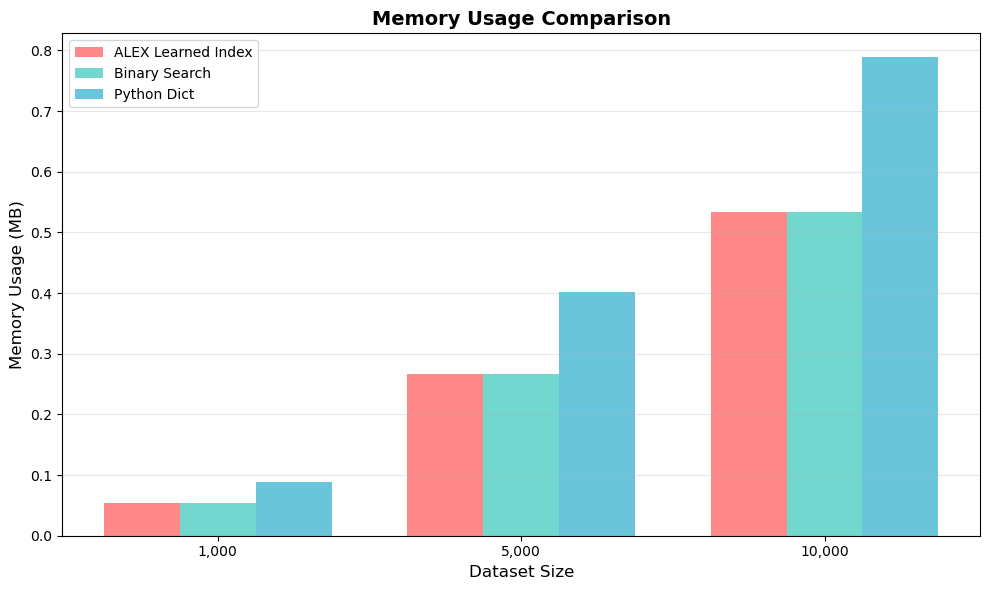

In [7]:
plt.figure(figsize=(10, 6))

for i, index_name in enumerate(index_names):
    memory_values = []
    for size in data_sizes:
        try:
            memory = results[size][index_name]['memory_mb']
            memory_values.append(memory)
        except:
            memory_values.append(0)
    
    x_pos = np.arange(len(data_sizes)) + i * 0.25
    plt.bar(x_pos, memory_values, width=0.25, label=index_name, color=colors[i], alpha=0.8)

plt.title('Memory Usage Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size', fontsize=12)
plt.ylabel('Memory Usage (MB)', fontsize=12)
plt.xticks(np.arange(len(data_sizes)) + 0.25, [f'{s:,}' for s in data_sizes])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'memory_usage.png'), dpi=300)
plt.show()

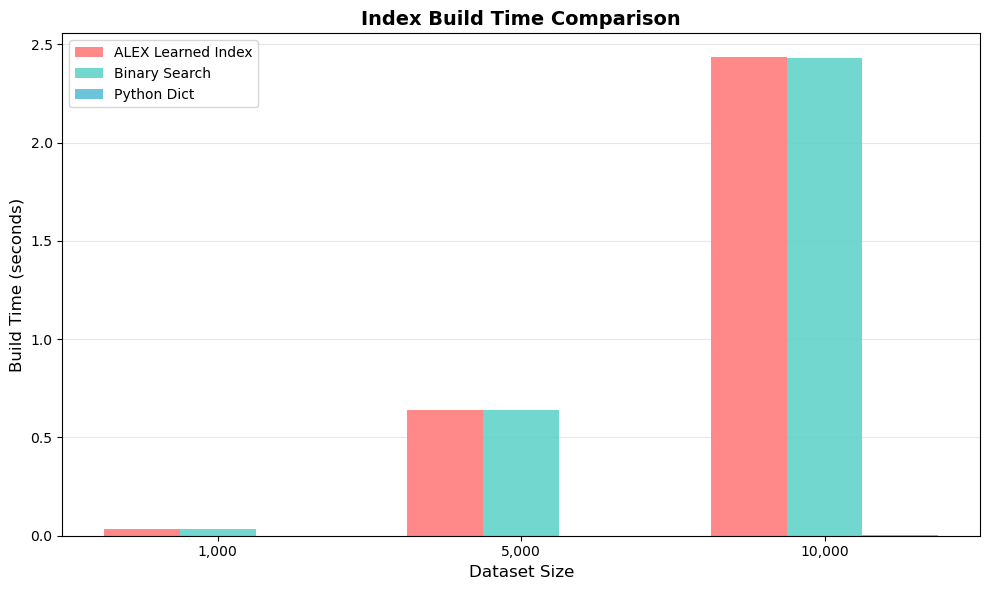

In [8]:
plt.figure(figsize=(10, 6))

for i, index_name in enumerate(index_names):
    build_values = []
    for size in data_sizes:
        try:
            build_time = results[size][index_name]['build_time']
            build_values.append(build_time)
        except:
            build_values.append(0)
    
    x_pos = np.arange(len(data_sizes)) + i * 0.25
    plt.bar(x_pos, build_values, width=0.25, label=index_name, color=colors[i], alpha=0.8)

plt.title('Index Build Time Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size', fontsize=12)
plt.ylabel('Build Time (seconds)', fontsize=12)
plt.xticks(np.arange(len(data_sizes)) + 0.25, [f'{s:,}' for s in data_sizes])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'build_time.png'), dpi=300)
plt.show()

In [9]:
# Results
print("SUMMARY: PERFORMANCE RESULTS")
for size in data_sizes:
    print(f"\nDataset Size: {size:,} records")
    print("-" * 90)
    
    print(f"{'Index':<20} {'Build':<8} {'Memory':<10} {'Point':<10} {'Point':<10} {'Range':<10} {'Mixed':<10}")
    print("-" * 90)
    
    for index_name in index_names:
        try:
            r = results[size][index_name]
            print(f"{index_name:<20} {r['build_time']:<8.3f} {r['memory_mb']:<10.2f} "
                  f"{r['point_avg_time']:<10.1f} {r['point_qps']:<10.0f} "
                  f"{r['range_qps']:<10.0f} {r['mixed_ops_per_sec']:<10.0f}")
        except:
            print(f"{index_name:<20} {'N/A':<8} {'N/A':<10} {'N/A':<10} {'N/A':<10} {'N/A':<10} {'N/A':<10}")

SUMMARY: PERFORMANCE RESULTS

Dataset Size: 1,000 records
------------------------------------------------------------------------------------------
Index                Build    Memory     Point      Point      Range      Mixed     
------------------------------------------------------------------------------------------
ALEX Learned Index   0.037    0.05       54.6       18313      8975       1000      
Binary Search        0.032    0.05       54.1       18489      9294       1000      
Python Dict          0.000    0.09       0.2        4201681    9994       1000      

Dataset Size: 5,000 records
------------------------------------------------------------------------------------------
Index                Build    Memory     Point      Point      Range      Mixed     
------------------------------------------------------------------------------------------
ALEX Learned Index   0.641    0.27       234.1      4272       2106       1000      
Binary Search        0.641    0.27     